# Intuition for the Maximum Mean Discrepancy two-sample test

_Thomas Viehmann_

This note sketches the intuition behind [A. Gretton et al.: A Kernel Two-Sample Test. JMLR 2012](http://www.gatsby.ucl.ac.uk/~gretton/mmd/mmd.htm).

Given a (high-dimensional) space $\mathbb{R}^d$ and iid samples $X_i \in \mathbb{R}^d, i=1,...N_X$ sampled from $X ~ P_X$ and $Y_i \in \mathbb{R}^d, i=1,...N_Y$ sampled from $Y ~ Y_X$, we may wish to make a statistical test of the hypothesis that $P_X$ is different from $P_Y$.

For simplicity, we stay in the classical, frequentist scheme.

So let us import the world:

In [1]:
import torch
%matplotlib inline
from matplotlib import pyplot
import tqdm

And then we can sample a few points (to facilitate plotting, we'll operate in 1-d, so not that high dimensional, but hey.)

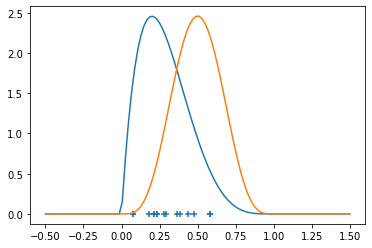

In [2]:
dist_x = torch.distributions.Beta(2, 5)
dist_y = torch.distributions.Beta(5, 5)
x = dist_x.sample((15,))
y = dist_y.sample((15,))
z = torch.linspace(-0.5, 1.5, 100)
pyplot.scatter(x, torch.zeros_like(x), marker='+')
raw_density_x = dist_x.log_prob(z).exp()
raw_density_y = dist_y.log_prob(z).exp()
density_x = torch.where(raw_density_x.isnan(), torch.tensor(0.0), raw_density_x)
density_y = torch.where(raw_density_y.isnan(), torch.tensor(0.0), raw_density_y)
pyplot.plot(z, density_x)
pyplot.plot(z, density_y)

One technique to estimating (the density of) $P_X$ (with $P_Y$ being analogous) is via a kernel (Kernel Density Estimation). Given a kernel, for example the Guassian or Radial Basis Function (RBF - but note that sometimes RBF is considered a general class) kernel $K(x,y) = C(\sigma, d) \exp\left(- \frac{|x-y|^2}{2\sigma^2}\right)$, for some fixed standard deviation $\sigma > 0$. We will not worry about the choice of $\sigma$ for now.

We can estimate $P_X$ as $\hat P_X(x) = \frac{1}{N_x} \sum_{i=1}^N K(X_i, x)$.

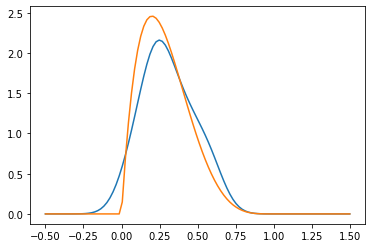

In [3]:
sigma = 0.1
raw_hat_p_x = torch.exp(-((x[None] - z[:, None])**2)/(2*sigma**2)).sum(1)
hat_p_x = (raw_hat_p_x / raw_hat_p_x.sum() / (z[1]-z[0]))
pyplot.plot(z, hat_p_x)
pyplot.plot(z, density_x)

Given our two samples, $X_i$ and $Y_i$, we may do this for both, so we have two probability densities $\hat P_X$ and $\hat P_Y$. Now, even if $P_X = P_Y$, we would not expect exact equality $\hat P_X = \hat P_Y$ due to the sampling and estimation error. But we would expect that they are somehow _close_.

To measure this closeness, we can look at our kernel again. It turns out that this is a so-call [reproducing kernel](https://en.wikipedia.org/wiki/Reproducing_kernel_Hilbert_space), that is if we define the two functions $K_x, K_y : \mathbb{R}^d \rightarrow \mathbb{R}$, $K_x(y) := K(x,y) =: K_y(x)$ we can define a scalar product on the Hilbert space spanned by such functions by setting $\langle K_x, K_y \rangle_{\mathcal{H}} := K(x,y)$, this is called a reproducing kernel Hilbert space in the literature. It turns out that for any function $f \in \mathcal{H}$, we have $f(x) = \langle f, K_x \rangle_\mathcal{H}$.

Clearly, our estimated distributions $\hat P_X$ and $\hat P_Y$ are in $\mathcal{H}$, so we can measure closeness in the norm of $\mathcal{H}$.

This leads to the maximum mean discrepancy test statistic $\widehat{MMD} = \| \hat P_X - \hat P_Y \|_{\mathcal{H}}^2$. By the the above representation, we can write

$$
\begin{aligned}
\widehat{MMD} &= \| \hat P_X - \hat P_Y \|_{\mathcal{H}} \\
        &= \langle \hat P_X - \hat P_Y, \hat P_X - \hat P_Y \rangle_{\mathcal{H}} \\
        &= \langle \hat P_X , \hat P_X \rangle_{\mathcal{H}} + \langle \hat P_Y, \hat P_Y \rangle_{\mathcal{H}}
           - 2 \langle \hat P_X , \hat P_Y \rangle_{\mathcal{H}} \\
        &= \sum_{i=1}^{N_X} \sum_{j=1}^{N_X} K(X_i, X_j) + \sum_{i=1}^{N_Y} \sum_{j=1}^{N_Y} K(Y_i, Y_j)
           - 2 \sum_{i=1}^{N_X} \sum_{j=1}^{N_Y} K(X_i, Y_j).
\end{aligned}
$$
This is relatively straightforward to compute.

In [4]:
def mmd(x, y, sigma):
    # compare kernel MMD paper and code:
    # A. Gretton et al.: A kernel two-sample test, JMLR 13 (2012)
    # http://www.gatsby.ucl.ac.uk/~gretton/mmd/mmd.htm
    # x shape [n, d] y shape [m, d]
    # n_perm number of bootstrap permutations to get p-value, pass none to not get p-value
    n, d = x.shape
    m, d2 = y.shape
    assert d == d2
    xy = torch.cat([x.detach(), y.detach()], dim=0)
    dists = torch.cdist(xy, xy, p=2.0)
    # we are a bit sloppy here as we just keep the diagonal and everything twice
    # note that sigma should be squared in the RBF to match the Gretton et al heuristic
    k = torch.exp((-1/(2*sigma**2)) * dists**2) + torch.eye(n+m)*1e-5
    k_x = k[:n, :n]
    k_y = k[n:, n:]
    k_xy = k[:n, n:]
    # The diagonals are always 1 (up to numerical error, this is (3) in Gretton et al.)
    # note that their code uses the biased (and differently scaled mmd)
    mmd = k_x.sum() / (n * (n - 1)) + k_y.sum() / (m * (m - 1)) - 2 * k_xy.sum() / (n * m)
    return mmd

Gretton et. al. recommend to set the parameter $\sigma$ to the median distance between points $\sigma = \mathrm{Median(|Z_i - Z_j|)/2}$ where $Z_\cdot$ is the combined sample of $X_\cdot$ and $Y_\cdot$. We stick with this recommendation without further questioning. In practice we might take the median of a reasonable subset (e.g. 100 samples).

In [5]:
dists = torch.pdist(torch.cat([x, y], dim=0)[:,None])
sigma = dists[:100].median()/2
our_mmd = mmd(x[:, None], y[:, None], sigma)
our_mmd

tensor(0.3407)

## Detecting different distributions

But now we need to make precise when $\hat P_X$ and $\hat P_Y$ are fare enough apart to say with some confidence that they $P_X$ and $P_Y$ are distinct.

Clearly, one option, in particular for evaluation of a detector, is to take the Receiver Operating Characteristic point of view and consider what any threshold for $\widehat{MMD}$ means in terms of true positives and false positives. This is what we do in our experiments.

## Bootstrapping

The other route is to try to give a threshold for a given confidence level or equivalently to convert $\widehat{MMD}$ values (given the sample sizes) into $p$-values. We could try to derived expressions for this (and earlier papers of the same group of authors do, see the link above), but the conceptually easiest way is to sample from the distribution $\widehat{MMD}$ under the null-hypothesis using bootstrapping. In this technique, we approximate sampling from the null-hypothesis by shuffeling between the $X_\cdot$ and $Y_\cdot$, so that both the $x$ and $y$ argument come from the same distribution. If one sample is sufficiently large (e.g. the training sample), we might compute the thresholds just on that, too.

*Note*: To do this efficiently, it is recommended to use custom CPU or GPU kernels.


In [6]:
N_X = len(x)
N_Y = len(y)
xy = torch.cat([x, y], dim=0)[:, None].double()

mmds = []
for i in tqdm.tqdm(range(1000)):
    xy = xy[torch.randperm(len(xy))]
    mmds.append(mmd(xy[:N_X], xy[N_X:], sigma).item())
mmds = torch.tensor(mmds)

100%|██████████| 1000/1000 [00:00<00:00, 4415.20it/s]


(array([ 73., 199., 198., 155., 124.,  62.,  66.,  37.,  26.,  18.,  11.,
          9.,   4.,   6.,   6.,   3.,   1.,   0.,   1.,   1.]),
 array([0.05134737, 0.07508753, 0.09882769, 0.12256785, 0.146308  ,
        0.17004816, 0.19378832, 0.21752848, 0.24126863, 0.2650088 ,
        0.28874895, 0.3124891 , 0.33622926, 0.35996944, 0.38370958,
        0.40744972, 0.4311899 , 0.45493007, 0.4786702 , 0.50241035,
        0.5261505 ], dtype=float32),
 <BarContainer object of 20 artists>)

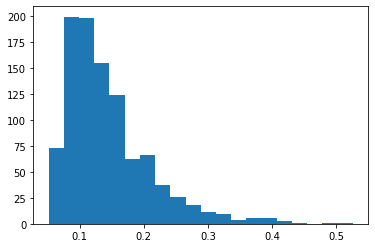

In [7]:
pyplot.hist(mmds.numpy(), bins=20)

With the empirical distribution, we can compute the threshold for a given probability $p$.

In [8]:
torch.quantile(mmds, 0.95) # threshold for 5% significance

tensor(0.2768)

Or we may assign a $p$-value to our observation:

In [9]:
(our_mmd < mmds).float().mean()

tensor(0.0220)

This concludes our short tour of the MMD statistic and the derived two-sample test.

I hope you enjoyed it, don't hesitate to E-Mail <tv@mathinf.eu> for questions and comments.